# Use-case: Deconvoluting drug responses in cancer cell lines 

This tutorial shows how to perform the analysis we present in Figure 3 of the [pertpy preprint](https://www.biorxiv.org/content/10.1101/2024.08.04.606516v1). We will use the [McFarland et al. 2020](https://doi.org/10.1038/s41467-020-17440-w) dataset, which contains single-cell RNA-seq data from 172 cancer cell lines treated with 13 drugs. We will first preprocess the data, annotate it with metadata, and compare it to bulk RNA-seq data. We will then deconvolute the drug response of each cell line into viability-dependent and -independent components. Overall, this tutorial demonstrates how to use pertpy to derive insights into perturbation responses in a complex dataset comprising various cell lines and drugs, with the goal of better understanding the molecular mechanisms underlying drug responses and how they vary across cell lines.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pertpy as pt
import scanpy as sc
import seaborn as sns
import statsmodels.api as sm
from tqdm import tqdm

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Load and preprocess data

The data can be obtained via pertpy's dataloader. Let's retrieve the data and perform some basic preprocessing.

In [2]:
adata = pt.dt.mcfarland_2020()
adata

AnnData object with n_obs × n_vars = 182875 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [3]:
adata.obs.head(10)

,DepMap_ID,cancer,cell_det_rate,cell_line,cell_quality,channel,disease,dose_unit,dose_value,doublet_CL1,...,singlet_z_margin,time,tissue_type,tot_reads,nperts,ngenes,ncounts,percent_mito,percent_ribo,chembl-ID
AAACCTGAGACAAGCC,ACH-000174,True,0.114940,CAL62,normal,nan,thyroid cancer,µM,5.0,CAL62_THYROID,...,14.820933,24,cell_line,1094,1,3758,17155.0,4.447683,28.079277,CHEMBL443684
AAACCTGAGAGATGAG,ACH-000601,True,0.122660,MIAPACA2,normal,nan,pancreatic cancer,µM,5.0,MIAPACA2_PANCREAS,...,14.746431,24,cell_line,1009,1,4009,19764.0,7.468124,25.460433,CHEMBL443684
AAACCTGAGCGTTGCC,ACH-000601,True,0.176608,MIAPACA2,normal,nan,pancreatic cancer,µM,5.0,MIAPACA2_PANCREAS,...,16.011316,24,cell_line,3022,1,5772,47352.0,2.755955,27.965028,CHEMBL443684
AAACCTGAGTAGGCCA,ACH-000950,True,0.177802,LOVO,normal,nan,colon/colorectal cancer,µM,5.0,LOVO_LARGE_INTESTINE,...,11.195382,24,cell_line,3732,1,5813,74069.0,6.356235,49.395834,CHEMBL443684
AAACCTGAGTTCGATC,ACH-000704,True,0.158993,OAW42,normal,nan,ovarian cancer,µM,5.0,OAW42_OVARY,...,10.590814,24,cell_line,2396,1,5200,38785.0,8.521336,35.255898,CHEMBL443684
AAACCTGAGTTGAGAT,ACH-000713,True,0.184940,CAOV3,normal,nan,ovarian cancer,µM,5.0,CAOV3_OVARY,...,15.769723,24,cell_line,3177,1,6046,49613.0,2.866184,25.840002,CHEMBL443684
AAACCTGCAATGAATG,ACH-000390,True,0.152774,LUDLU1,empty_droplet,nan,lung cancer,µM,5.0,LUDLU1_LUNG,...,0.073927,24,cell_line,2026,1,4996,27298.0,9.293721,16.557990,CHEMBL443684
AAACCTGCACATGTGT,ACH-000966,True,0.129431,IGROV1,empty_droplet,nan,ovarian cancer,µM,5.0,IGROV1_OVARY,...,0.799263,24,cell_line,1490,1,4233,27735.0,4.575446,38.629890,CHEMBL443684
AAACCTGCACGGCGTT,ACH-000368,True,0.163496,SNU1105,normal,nan,brain cancer,µM,5.0,SNU1105_CENTRAL_NERVOUS_SYSTEM,...,8.935577,24,cell_line,2416,1,5345,40236.0,2.192067,29.033701,CHEMBL443684
AAACCTGCACTTAACG,ACH-000749,True,0.119689,DMS273,normal,nan,lung cancer,µM,5.0,DMS273_LUNG,...,18.328158,24,cell_line,1158,1,3914,21471.0,6.571655,37.380653,CHEMBL443684


In [5]:
adata.obs["perturbation_type"].value_counts()

perturbation_type
drug      154710
CRISPR     28165
Name: count, dtype: int64

In [4]:
adata.obs["perturbation"].value_counts()

perturbation
Trametinib     41300
control        29143
BRD3379        21206
Dabrafenib     12814
Navitoclax      9623
sgLACZ          7567
sgOR2J2         7250
AZD5591         7098
sgGPX4-2        6831
sgGPX4-1        6517
Idasanutlin     5990
JQ1             5591
Bortezomib      5150
Prexasertib     3972
Everolimus      3825
Afatinib        3807
Taselisib       3098
Gemcitabine     2093
Name: count, dtype: int64

The dataset is annotated with various metrics for cell quality control, and information of cell line, including the cancer type, as well as details on the perturbation applied. The perturbations comprise CRISPR knockouts and drug treatments. We only want to look at the drug perturbations in this analysis, so we will filter out cells that were treated with other perturbations.

In [6]:
adata = adata[adata.obs["perturbation_type"] == "drug"]
adata

View of AnnData object with n_obs × n_vars = 154710 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

We will now perform some standard preprocessing steps on the data, such as filtering out low-quality cells and normalizing the data, and identifying highly variable genes. As we will use EdgeR for differential expression analysis, which requires raw counts, we will also save the raw counts in the `raw_counts` layer.

In [7]:
sc.pp.filter_genes(adata, min_cells=30)

adata.layers["raw_counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


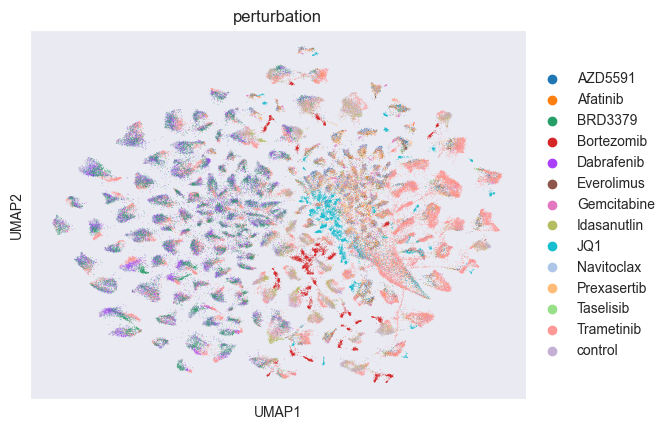

In [8]:
sc.pp.neighbors(adata)
sc.pp.pca(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="perturbation")

## Metadata annotation

Datasets often come with metadata that can enable more detailed analyses, as those presented in this tutorial. However, the extent of metadata can vary greatly between datasets, and each dataset usually has its own metadata format. To address this, databases that allow for standardized metadata annotation exist. Pertpy offers multiple metadata classes to query these databases and annotate your data. Here, we will use the `CellLine` and `Moa` classes to annotate the cell lines and mechanisms of action (MOA) of the drugs, respectively.

In [6]:
cl_metadata = pt.md.CellLine()
cl_metadata.annotate(
    adata,
    query_id="DepMap_ID",
    reference_id="ModelID",
    fetch=["CellLineName", "Age", "OncotreePrimaryDisease", "SangerModelID", "OncotreeLineage"],
)

AnnData object with n_obs × n_vars = 154710 × 24424
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'CellLineName', 'Age', 'OncotreePrimaryDisease', 'SangerModelID', 'OncotreeLineage'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    uns: 'log1p', 'neighbors', 'pca', 'umap', 'perturbation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts'
    obsp: 'distances', 'connectivities'

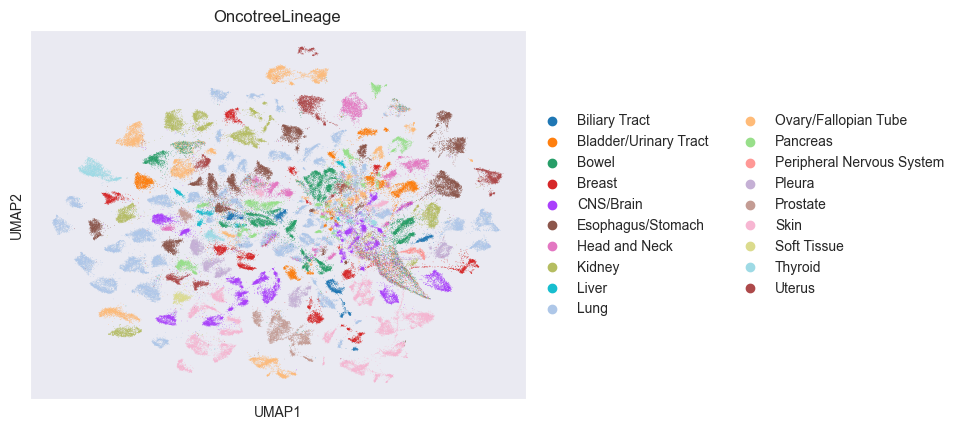

In [7]:
sc.pl.umap(adata, color=["OncotreeLineage"])

In [8]:
moa_metadata = pt.md.Moa()
moa_metadata.annotate(
    adata,
    query_id="perturbation",
)

# Add control annotations
adata.obs["moa"] = [
    "Control" if pert == "control" else moa for moa, pert in zip(adata.obs["moa"], adata.obs["perturbation"])
]
adata.obs["target"] = [
    "Control" if pert == "control" else target for target, pert in zip(adata.obs["target"], adata.obs["perturbation"])
]

💡 There are 14 identifiers in `adata.obs`.However, 5 identifiers can't be found in the moa annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


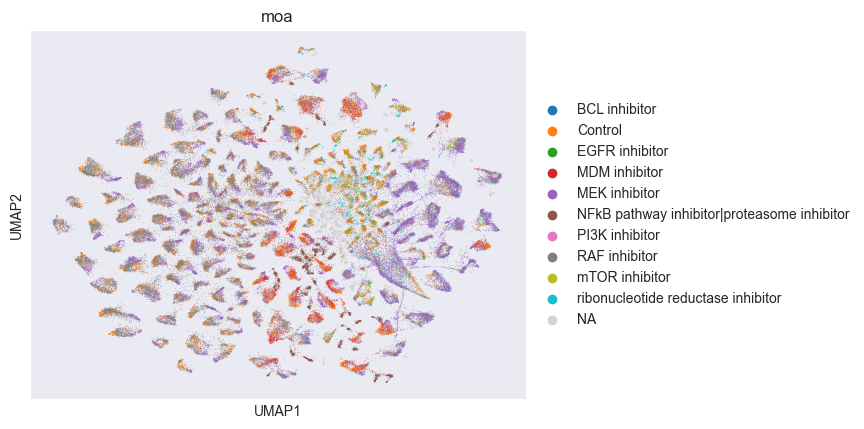

In [9]:
sc.pl.umap(adata, color=["moa"])

Next, we will annotate the dataset with GDSC IC50 values, which indicate the drug response of each cell line to each drug. We will use the `GDSC` class for this purpose. Note that we will use the previously queried `SangerModelID` as cell line name for this step. There are two versions of the dataset: GDSC1 and GDSC2. We will annotate the dataset with both versions.


In [10]:
cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation="perturbation",
    gdsc_dataset="gdsc_1",
)
adata.obs["ln_ic50_GDSC1"] = adata.obs["ln_ic50"].copy()

cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation="perturbation",
    gdsc_dataset="gdsc_2",
)
adata.obs["ln_ic50_GDSC2"] = adata.obs["ln_ic50"].copy()

del adata.obs["ln_ic50"]
adata

💡 There are 140 identifiers in `adata.obs`.However, 25 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...
💡 There are 140 identifiers in `adata.obs`.However, 25 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


AnnData object with n_obs × n_vars = 154710 × 24424
    obs: 'SangerModelID', 'perturbation', 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'CellLineName', 'Age', 'OncotreePrimaryDisease', 'OncotreeLineage', 'moa', 'target', 'ln_ic50_GDSC1', 'ln_ic50_GDSC2'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    uns: 'log1p', 'neighbors', 'pca', 'umap', 'perturbation_colors', 'OncotreeLineage_colors', 'moa_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts'
    obsp: 'distances', 'connectivities'

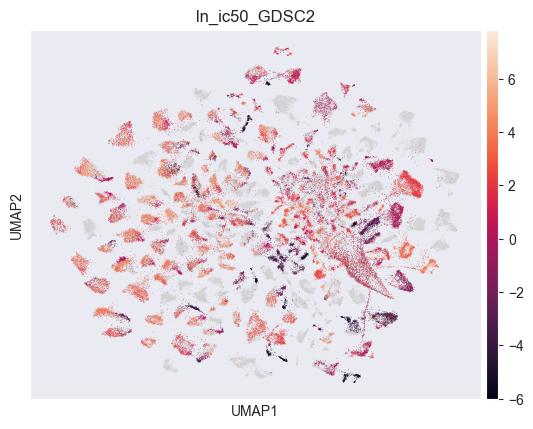

In [11]:
sc.pl.umap(adata, color=["ln_ic50_GDSC2"])

## Comparison to bulk RNA-seq data

One question we might have after sequencing an in vitro experiment is “How similar are our expression profiles compared to the public database?” To answer this, we generate “pseudobulks” by aggregating counts to the cell-type level and then compare them with bulk RNA-seq data.

In [12]:
ps = pt.tl.PseudobulkSpace()
pdata = ps.compute(adata, target_col="CellLineName", groups_col="perturbation")

In [13]:
base_line = pdata[pdata.obs.perturbation == "control"]
base_line.obs.index = base_line.obs.index.str.replace("_control", "")

In [14]:
cl_metadata.annotate_bulk_rna(base_line, cell_line_source="broad", query_id="DepMap_ID")

❗ To annotate bulk RNA data from Broad Institue, `DepMap_ID` is used as default reference and query identifier if no `reference_id` is given.
Ensure that `DepMap_ID` is available in 'adata.obs'.
Alternatively, use `annotate()` to annotate the cell line first 
💡 There are 170 identifiers in `adata.obs`.However, 1 identifiers can't be found in the bulk RNA annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


AnnData object with n_obs × n_vars = 170 × 24424
    obs: 'SangerModelID', 'perturbation', 'DepMap_ID', 'cancer', 'cell_line', 'disease', 'dose_unit', 'dose_value', 'organism', 'perturbation_type', 'sex', 'singlet_ID', 'tissue_type', 'nperts', 'chembl-ID', 'CellLineName', 'Age', 'OncotreePrimaryDisease', 'OncotreeLineage', 'moa', 'target', 'ln_ic50_GDSC1', 'ln_ic50_GDSC2', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    obsm: 'bulk_rna_broad'
    layers: 'psbulk_props'

In [15]:
base_line.obsm["bulk_rna_broad"].head(5)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288714,ENSG00000288717,ENSG00000288718,ENSG00000288719,ENSG00000288720,ENSG00000288721,ENSG00000288722,ENSG00000288723,ENSG00000288724,ENSG00000288725
22Rv1,2.179511,0.0,6.316146,3.407353,4.642702,0.014355,0.124328,5.816088,7.045814,5.057017,...,0.000000,0.000000,0.000000,0.028569,0.250962,0.432959,3.875780,0.137504,0.0,0.000000
253J-BV,3.942045,0.0,5.967169,1.883621,3.581351,0.000000,0.084064,5.087463,4.444932,3.794936,...,0.000000,0.201634,0.124328,0.000000,0.150560,0.526069,4.526069,0.214125,0.0,0.000000
42-MG-BA,3.880686,0.0,6.733083,1.922198,3.390943,0.028569,0.575312,5.816856,3.313246,3.903038,...,0.028569,0.000000,0.042644,0.014355,0.070389,0.555816,2.601697,0.000000,0.0,0.084064
5637,5.128871,0.0,6.691534,2.010780,4.976364,0.163499,1.636915,6.193575,3.505891,3.709291,...,0.000000,0.000000,0.150560,0.028569,0.014355,0.298658,2.978196,0.000000,0.0,0.000000
639-V,4.328406,0.0,7.058749,1.891419,3.529821,0.000000,3.878725,6.432792,4.698774,4.912650,...,0.028569,0.201634,0.028569,0.056584,0.189034,0.505891,3.820690,0.000000,0.0,0.000000


In [16]:
# We can only correlate the expression of genes that are present in both datasets, hence we filter the data accordingly
overlapping_genes = set(base_line.var.ensembl_id) & set(base_line.obsm["bulk_rna_broad"].columns)
base_line = base_line[:, base_line.var["ensembl_id"].isin(overlapping_genes)]
base_line.obsm["bulk_rna_broad"] = base_line.obsm["bulk_rna_broad"][base_line.var.ensembl_id]

Next, we log-transform the bulk RNA-seq data and correlate the pseudobulks with the bulk RNA-seq data to see how similar the expression profiles are.

In [17]:
sc.pp.log1p(base_line)
corr, pvals, unmatched_cl_corr, unmatched_cl_pvals = cl_metadata.correlate(
    base_line, identifier="DepMap_ID", metadata_key="bulk_rna_broad"
)

❗ Column name of metadata is not the same as the index of adata.var. Ensure that the genes are in the same order.


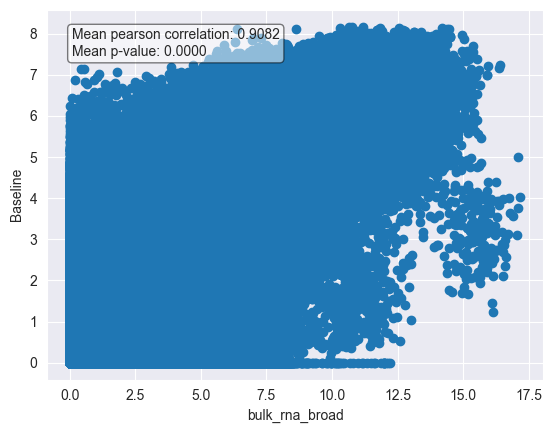

In [18]:
# Visualize the correlation of cell lines by scatter plot
cl_metadata.plot_correlation(
    base_line,
    corr=corr,
    pval=pvals,
    identifier="DepMap_ID",
    metadata_key="bulk_rna_broad",
    subset_identifier=None,
)

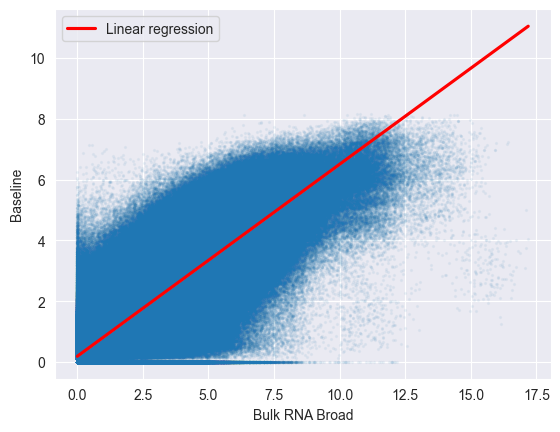

In [19]:
plot_df = pd.DataFrame(
    {
        "Bulk RNA Broad": base_line.obsm["bulk_rna_broad"].to_numpy().flatten(),
        "Baseline": base_line.X.flatten(),
    }
)

sns.regplot(
    x="Bulk RNA Broad",
    y="Baseline",
    data=plot_df,
    ci=99,
    scatter_kws={"s": 2, "alpha": 0.05},
    line_kws={"color": "red", "label": "Linear regression"},
)

plt.legend()

The correlation between the pseudobulks and the bulk RNA-seq data is quite high, indicating that the expression profiles of the cell lines in the McFarland dataset are similar to those in the bulk RNA-seq data.

## Deconvoluting drug responses

Above, we have annotated our dataset with GDSC IC50 values, indicating the drug response of each cell line to each drug. We can now use this information to deconvolute the drug response of each cell line into viability-dependent and -independent components.

Let's first check the correlation between the IC50 values of the two GDSC datasets:

In [20]:
adata.obs[["ln_ic50_GDSC1", "ln_ic50_GDSC2"]].corr()

,ln_ic50_GDSC1,ln_ic50_GDSC2
ln_ic50_GDSC1,1.000000,0.839123
ln_ic50_GDSC2,0.839123,1.000000


In [21]:
# Check for how many cell lines we have GDSC data for the different drugs
adata.obs[["perturbation", "ln_ic50_GDSC2"]].drop_duplicates()["perturbation"].value_counts()

perturbation
Trametinib     115
Navitoclax      68
Dabrafenib      67
Afatinib        65
Gemcitabine     65
Taselisib       64
JQ1             63
Bortezomib      16
AZD5591          1
BRD3379          1
Everolimus       1
Idasanutlin      1
Prexasertib      1
control          1
Name: count, dtype: int64

We will look into the Dabrafenib drug response and deconvolute it into viability-dependent and -independent response, as shown in the [McFarland et al. 2020 paper](https://doi.org/10.1038/s41467-020-17440-w). We will use the EdgeR package for this analysis.

Precisely, we will perform the following steps:
1. Obtain log-fold changes (logFC) for each gene in each cell line treated with Dabrafenib compared to the control.
2. Perform linear regression between the logFC values and the GDSC IC50 values to obtain the slope and intercept for each gene.
3. Visualize the results in a volcano plot.

Let's start with the first step:

In [ ]:
adata_dabrafenib = adata[adata.obs["perturbation"].isin(["control", "Dabrafenib"])]

logfc_df = pd.DataFrame(columns=adata_dabrafenib.var_names)

for cell_line in tqdm(adata_dabrafenib.obs["SangerModelID"].unique()):
    subset = adata_dabrafenib[adata_dabrafenib.obs["SangerModelID"] == cell_line]
    if subset.n_obs < 20:  # Threshold from the McFarland paper
        continue
    if "Dabrafenib" not in subset.obs["perturbation"].unique():
        continue

    edgr = pt.tl.EdgeR(subset, design="~perturbation", layer="raw_counts")
    edgr.fit()

    res_df = edgr.test_contrasts(edgr.contrast("perturbation", "control", "Dabrafenib"))
    res_df = res_df[["variable", "log_fc"]]
    res_df = res_df.set_index("variable")
    res_df = res_df.reindex(adata.var_names)

    logfc_df.loc[cell_line] = res_df["log_fc"]

logfc_df.to_csv("output/logfc_df_dabrafenib.csv")

In [23]:
logfc_df = pd.read_csv("output/logfc_df_dabrafenib.csv", index_col=0)
logfc_df = logfc_df.loc[:, (logfc_df != 0).any(axis=0)]

Now that we have the log-fold changes for each gene in each cell line treated with Dabrafenib, we can perform linear regression between the log-fold changes and the GDSC IC50 values to obtain the slope and intercept for each gene. The slope represents the viability-dependent response, while the intercept represents the viability-independent response.

We will use the GDSC2 dataset for this analysis, but you can also use the GDSC1 dataset by changing the `gdsc_dataset` parameter.

In [24]:
gdsc_dataset = 2  # We will use GDSC2 dataset for this analysis

lr_params = pd.DataFrame(columns=["gene", "slope", "intercept", "slope_pval", "intercept_pval"])

cell_lines = logfc_df.index
sens_cell_lines = (
    adata_dabrafenib.obs[[f"ln_ic50_GDSC{gdsc_dataset}", "SangerModelID"]]
    .drop_duplicates()
    .dropna()
    .set_index("SangerModelID")
)
cell_lines = [cell_line for cell_line in cell_lines if cell_line in sens_cell_lines.index]

X = sens_cell_lines.loc[cell_lines][f"ln_ic50_GDSC{gdsc_dataset}"].values
na_mask = np.isnan(X)
X = X[~na_mask]

for gene in tqdm(logfc_df.columns):
    y = logfc_df.loc[cell_lines][gene].values
    y = y[~na_mask]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()

    lr_params.loc[gene] = [gene, results.params[1], results.params[0], results.pvalues[1], results.pvalues[0]]

# Filter out with both zero slope AND intercept
lr_params = lr_params[(lr_params["slope"] != 0) | (lr_params["intercept"] != 0)]

# Multiple testing correction
lr_params["slope_pval_corrected"] = sm.stats.multipletests(lr_params["slope_pval"], method="fdr_bh")[1]
lr_params["intercept_pval_corrected"] = sm.stats.multipletests(lr_params["intercept_pval"], method="fdr_bh")[1]

lr_params["-log10(slope_pval_corrected)"] = -np.log10(lr_params["slope_pval_corrected"])
lr_params["-log10(intercept_pval_corrected)"] = -np.log10(lr_params["intercept_pval_corrected"])

lr_params.to_csv("output/linear_regression_results_dabrafenib.csv")

100%|██████████| 24424/24424 [01:15<00:00, 325.36it/s]


In [25]:
lr_params.head(5)

,gene,slope,intercept,slope_pval,intercept_pval,slope_pval_corrected,intercept_pval_corrected,-log10(slope_pval_corrected),-log10(intercept_pval_corrected)
RP11-34P13.7,RP11-34P13.7,0.000017,0.005576,0.997914,0.863109,0.999077,0.954066,0.000401,0.020422
AL627309.1,AL627309.1,0.002542,0.008615,0.779733,0.849677,0.940812,0.948825,0.026497,0.022814
AP006222.2,AP006222.2,0.027225,-0.045638,0.100015,0.577922,0.365464,0.822735,0.437156,0.084740
RP4-669L17.10,RP4-669L17.10,-0.015041,0.039887,0.088418,0.362479,0.339679,0.661822,0.468932,0.179258
RP4-669L17.2,RP4-669L17.2,-0.000496,0.005325,0.763366,0.518953,0.933945,0.785116,0.029679,0.105066


Let's plot the genes that show a particularly high viability-independent response to Dabrafenib, using pertpy's volcano plot implementation:

In [16]:
# We will not actually use the EdgeR method here, we just create the object so that we can subsequently use the plot_volcano method
edgr = pt.tl.EdgeR(adata, design="~perturbation", layer="raw_counts")

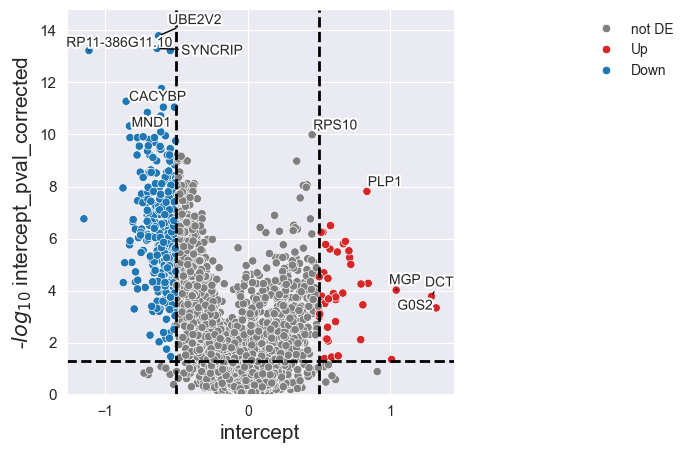

In [20]:
edgr.plot_volcano(
    lr_params,
    log2fc_col="intercept",
    pvalue_col="intercept_pval_corrected",
    symbol_col="gene",
    pval_thresh=0.05,
    log2fc_thresh=0.5,
)

The volcano plot above shows the viability-independent response of each gene to Dabrafenib, represented by the intercept. We can also look at the linear regression for individual genes. Let's pick the gene EGR1 with a highly negative intercept and visualize the linear regression between the log-fold changes and the GDSC IC50 values:

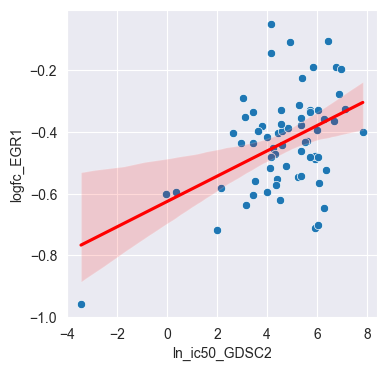

In [28]:
cell_lines = logfc_df.index
sens_cell_lines = (
    adata_dabrafenib.obs[[f"ln_ic50_GDSC{gdsc_dataset}", "SangerModelID"]]
    .drop_duplicates()
    .dropna()
    .set_index("SangerModelID")
)
cell_lines = [cell_line for cell_line in cell_lines if cell_line in sens_cell_lines.index]

X = sens_cell_lines.loc[cell_lines][f"ln_ic50_GDSC{gdsc_dataset}"].values
na_mask = np.isnan(X)
X = X[~na_mask]

y = logfc_df.loc[cell_lines]["UBE2V2"].values
y = y[~na_mask]
X = sm.add_constant(X)

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    x=X[:, 1],
    y=y,
    ax=ax,
)

sns.regplot(
    x=X[:, 1],
    y=y,
    scatter=False,
    color="red",
    ax=ax,
)

ax.set_xlabel(f"ln_ic50_GDSC{gdsc_dataset}")
ax.set_ylabel("logfc_EGR1")
plt.show()

Similarly, we can examine the viability-dependent response of each gene to Dabrafenib, represented by the slope:

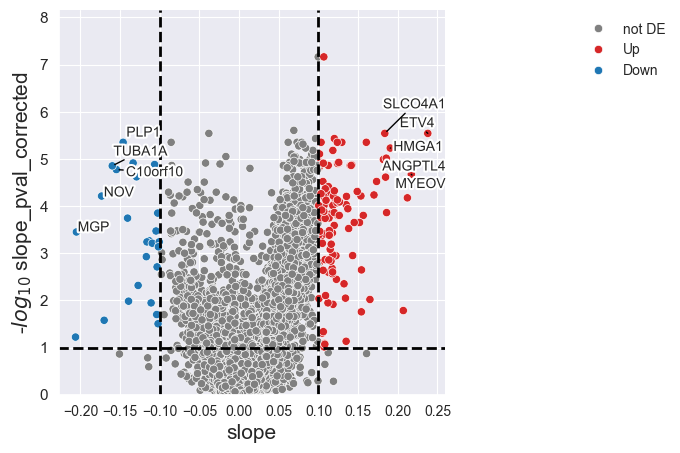

In [22]:
edgr.plot_volcano(
    lr_params,
    log2fc_col="slope",
    pvalue_col="slope_pval_corrected",
    symbol_col="gene",
    pval_thresh=0.1,
    log2fc_thresh=0.1,
)

## Conclusion
Overall, we have deconvoluted the drug response of cell lines to Dabrafenib treatment into viability-dependent and -independent components. This analysis can provide insights into the molecular mechanisms underlying drug responses and pertpy can help you perform this analysis in a straightforward manner. For further details on the analysis and to see the results when performing this analysis with another drug, please refer to the [pertpy preprint](https://www.biorxiv.org/content/10.1101/2024.08.04.606516v1).